In [1]:
import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
print(tf.__version__)

2.16.1


In [2]:
from tensorflow import keras
from keras.datasets import mnist
import numpy as np
np.set_printoptions(precision=2)

import matplotlib.pyplot as plt

## MNIST data


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
x_train = x_train.astype('float')/255.0
x_test = x_test.astype('float')/255.0

### Part 1: PCA


In [5]:
x_train_flat = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flat = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train_flat.shape)
print(x_test_flat.shape)

(60000, 784)
(10000, 784)


In [6]:
from sklearn.preprocessing import StandardScaler
x_train_scaled = StandardScaler().fit_transform(x_train_flat)

In [7]:
from sklearn.decomposition import PCA

def mnist_pca(x_data, n_components):
    pca = PCA(n_components=n_components)

    fit_pca = pca.fit(x_data)
    
    print("Variance explained with {0} components:".format(n_components), 
          round(sum(fit_pca.explained_variance_ratio_), 2))

    return fit_pca, fit_pca.transform(x_data)

In [8]:
pca_full, mnist_data_full = mnist_pca(x_train_scaled, 784)

Variance explained with 784 components: 1.0


In [9]:
pca_2, mnist_data_2 = mnist_pca(x_train_scaled, 2)

Variance explained with 2 components: 0.1


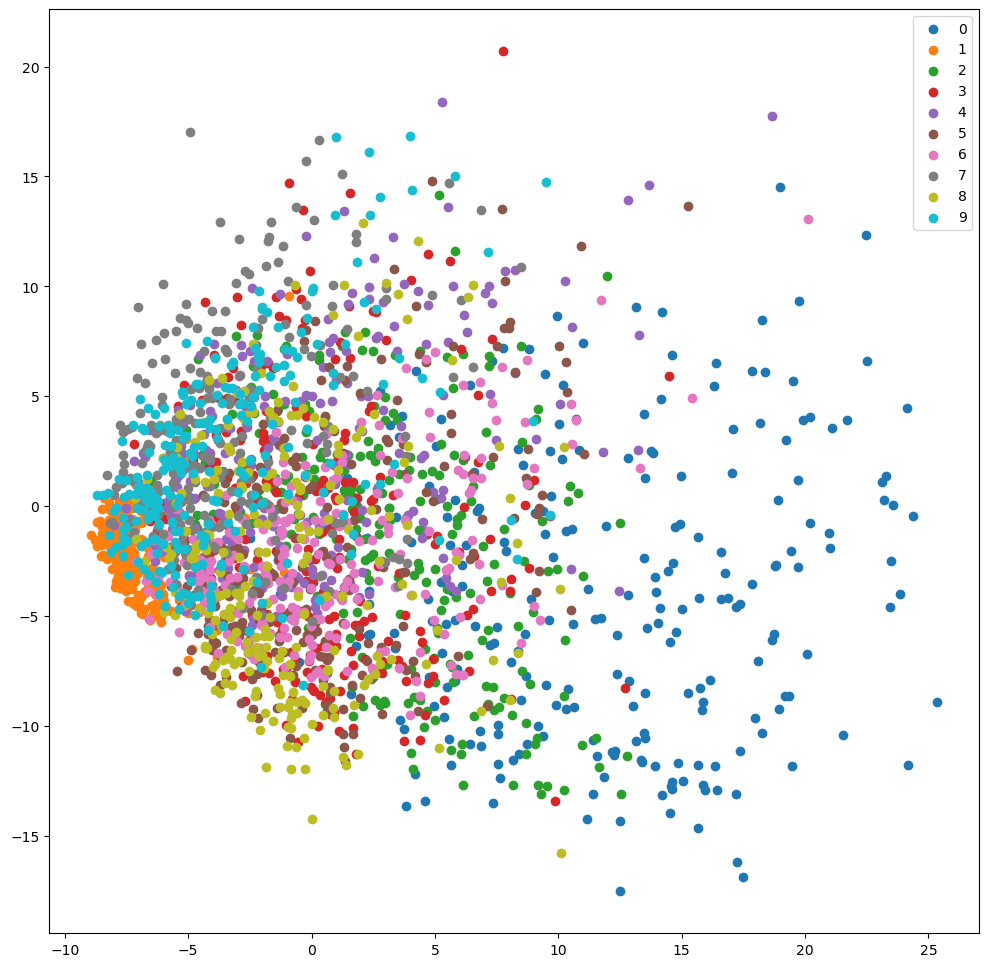

In [10]:
num_images_per_class = 250
fig = plt.figure(figsize=(12,12))
for number in list(range(10)):
    mask = y_train == number
    x_data = mnist_data_2[mask, 0][:num_images_per_class]
    y_data = mnist_data_2[mask, 1][:num_images_per_class]
    plt.scatter(x_data, y_data, label=number, alpha=1)
plt.legend();

### Scoring PCA


In [11]:
pca_64, mnist_data_64 = mnist_pca(x_train_scaled, 64)

Variance explained with 64 components: 0.6


In [12]:
s = StandardScaler().fit(x_test_flat)
x_test_scaled = s.transform(x_test_flat)

In [13]:
x_test_flat_64 = pca_64.transform(x_test_scaled)
x_test_reconstructed_64 = pca_64.inverse_transform(x_test_flat_64)

In [14]:
x_test_reconstructed_64.shape

(10000, 784)

In [15]:
true = x_test_scaled

In [16]:
reconstructed = x_test_reconstructed_64

In [17]:
def mse_reconstruction(true, reconstructed):
    return np.sum(np.power(true - reconstructed, 2) / true.shape[1])

In [18]:
mse_reconstruction(true, reconstructed)

3160.379819861438

### Simple AE


In [19]:
from keras.layers import Input, Dense
from keras.models import Model

In [20]:
encoding_dim = 64
inputs = Input(shape=(784, ))
encoded = Dense(encoding_dim, activation='sigmoid')(inputs)
encoder_model = Model(inputs, encoded, name='encoder')

encoded_inputs = Input(shape=(encoding_dim,), name='encoding')
reconstruction=Dense(784, activation='sigmoid')(encoded_inputs)
decoder_model = Model(encoded_inputs, reconstruction, name='decoder')

outputs = decoder_model(encoder_model(inputs))

full_model = Model(inputs, outputs, name='full_ae')

In [21]:
full_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
hsitory = full_model.fit(x_train_flat, x_train_flat, shuffle=True, epochs=1, batch_size = 32)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 35s 17ms/step - accuracy: 0.0101 - loss: 0.3016


In [23]:
encoded_images = encoder_model.predict(x_test_flat)
encoded_images.shape

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


(10000, 64)

In [24]:
encoded_images[0]

array([0.92, 0.94, 0.97, 0.95, 0.99, 0.75, 0.97, 0.98, 0.96, 0.97, 0.97,
       0.97, 0.99, 0.95, 0.96, 0.98, 0.96, 0.94, 0.92, 0.97, 0.91, 0.95,
       0.97, 0.97, 0.98, 0.98, 0.87, 0.98, 0.96, 0.96, 0.97, 0.98, 0.95,
       0.98, 0.97, 0.97, 0.96, 0.79, 0.89, 0.96, 0.96, 0.97, 0.89, 0.97,
       0.97, 0.97, 0.97, 0.84, 0.96, 0.98, 0.99, 0.98, 0.97, 0.93, 0.95,
       0.97, 0.98, 0.98, 0.98, 0.82, 0.96, 0.97, 0.99, 0.95],
      dtype=float32)

### Exercise 1

With PCA, we compared the pixel-wise difference between the reconstructed images and the original images to score how good the model was. 

Your task is now to do the same using the autoencoder. You'll have to think about what needs to get fed through the autoencoder to do this. Your steps are:

1. Use the trained autoencoder to generate reconstructed images.
2. Compute the pixel-wise distance between the reconstructed images and the original images. 

Is your result higher or lower than what you got with PCA?


In [25]:
decoded_images = full_model.predict(x_test_flat)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


In [27]:
mse_reconstruction(decoded_images, x_test_flat)

664.4192054835518

### Exercise 2:

One of the reasons this model does worse than PCA is that is isn't a "Deep Learning" model. Go ahead and add an extra hidden Dense layer to both the `encoder_model` and the `decoder_model`.


In [28]:
ENCODING_DIM = 64
HIDDEN_DIM = 256
### BEGIN SOLUTION
# Encoder model
inputs = Input(shape=(784,)) 
encoded = Dense(ENCODING_DIM, activation="relu")(inputs)
encoder_hidden = Dense(HIDDEN_DIM, activation="sigmoid")(encoded)
encoder_model = Model(inputs, encoded, name='encoder')

# Decoder model
encoded_inputs = Input(shape=(ENCODING_DIM,), name='encoding')
decoder_hidden = Dense(HIDDEN_DIM, activation="relu")(encoded_inputs)
reconstruction = Dense(784, activation="sigmoid")(decoder_hidden)
decoder_model = Model(encoded_inputs, reconstruction, name='decoder')

# Defining the full model as the combination of the two
outputs = decoder_model(encoder_model(inputs))
full_model = Model(inputs, outputs, name='full_ae')

In [29]:
full_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

In [30]:
history = full_model.fit(x_train_flat, x_train_flat, shuffle=True, epochs=2, batch_size=32)

Epoch 1/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 46s 22ms/step - accuracy: 0.0114 - loss: 0.2138
Epoch 2/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 43s 23ms/step - accuracy: 0.0125 - loss: 0.1054


In [31]:
decoded_images = full_model.predict(x_test_flat)
mse_reconstruction(decoded_images, x_test_flat)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step


98.76966959160609

### Exercise 3:You've probably noticed we've only been training our model for one epoch. Let's test to see how our model's reconstruction loss decreases as we train it more. 

Write code that:

1. Trains the autoencoder for 5 epochs
2. Prints the reconstruction loss after each epoch

Does the reconstruction loss decrease after each epoch?



In [34]:
def train_ae_epochs(num_epochs=1):
    ENCODING_DIM = 64
    HIDDEN_DIM = 256

    
    inputs = Input(shape=(784,)) 
    encoded = Dense(ENCODING_DIM, activation="relu")(inputs)
    encoder_hidden = Dense(HIDDEN_DIM, activation="sigmoid")(encoded)
    encoder_model = Model(inputs, encoded, name='encoder')


    encoded_inputs = Input(shape=(ENCODING_DIM,), name='encoding')
    decoder_hidden = Dense(HIDDEN_DIM, activation="relu")(encoded_inputs)
    reconstruction = Dense(784, activation="sigmoid")(decoder_hidden)
    decoder_model = Model(encoded_inputs, reconstruction, name='decoder')

    
    outputs = decoder_model(encoder_model(inputs))
    full_model = Model(inputs, outputs, name='full_ae')
    
    full_model = Model(inputs=inputs, 
                       outputs=outputs)

    full_model.compile(optimizer='rmsprop',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
    mse_res = []
    for i in range(num_epochs):
        history = full_model.fit(x_train_flat, x_train_flat, shuffle=True, epochs=1, batch_size=32)
    
        decoded_images = full_model.predict(x_test_flat)
        reconstruction_loss = mse_reconstruction(decoded_images, x_test_flat)
        mse_res.append(reconstruction_loss)
        print("Reconstruction loss after epoch {0} is {1}"
              .format(i+1, reconstruction_loss))     
    return mse_res

In [33]:
train_ae_epochs(5)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 46s 22ms/step - accuracy: 0.0097 - loss: 0.2138
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
Reconstruction loss after epoch 1 is 145.59118789062416
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 39s 21ms/step - accuracy: 0.0117 - loss: 0.1054
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Reconstruction loss after epoch 2 is 95.15672161926783
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 44s 24ms/step - accuracy: 0.0134 - loss: 0.0926
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Reconstruction loss after epoch 3 is 78.50550849400219
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 45s 24ms/step - accuracy: 0.0122 - loss: 0.0865
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Reconstruction loss after epoch 4 is 69.1478773516853
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 45s 24ms/step - accuracy: 0.0123 - loss: 0.0834
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Reconstruction loss after epoch 5 is 58.135332133074364


[145.59118789062416,
 95.15672161926783,
 78.50550849400219,
 69.1478773516853,
 58.135332133074364]

### Variational autoencoderVAEs are a way have neural networks learn representations of data, as with regular autoencoders. This time, however, the neural network will learn parameters of a normal distribution that will have observations drawn from it that will be transformed back into images. This results in two dimensional latent representation of the data once the variational autoencoder is trained, where one dimension represents the mean of the normal distribution and the other dimension represents the standard deviation.
At a high level, the actual steps of a VAE are:

1. The first neural network, the "encoder", predicts two vectors for each image, which will then be interpreted as means and standard deviations and transformed into a normal distribution.
3. The second neural network, the "decoder", takes the results of this operation and tries to reconstruct the original image.
4. The entire system is trained with backpropagation. At each iteration, _two_ losses are computed:
    * One loss simply penalizes the system for producing images that don't match the original images.
    * The other loss penalizes the encoder model for not correctly producing statistics from the image that match a standard normal distribution. 
   
The details are contained in the presentation. 




In [42]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os

In [37]:
def sampling(args):
    """
    Transforms parameters defining the latent space into a normal distribution.
    """
    # Need to unpack arguments like this because of the way the Keras "Lambda" function works.
    mu, log_sigma = args
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=tf.shape(mu))
    sigma = K.exp(log_sigma)
    return mu + K.exp(0.5 * sigma) * epsilon

In [45]:
from keras.losses import MeanSquaredError, binary_crossentropy


In [46]:
hidden_dim = 256
batch_size = 128
latent_dim = 2 
# this is the dimension of each of the vectors representing the two parameters
# that will get transformed into a normal distribution
epochs = 1


# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=(784, ), name='encoder_input')
x = Dense(hidden_dim, activation='relu')(inputs)


z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# NOTE: output of encoder model is *2* n-dimensional vectors:

z = Lambda(sampling, name='z')([z_mean, z_log_var])
# z is now one n dimensional vector representing the inputs 
encoder_model = Model(inputs, [z_mean, z_log_var, z], name='encoder')

NotImplementedError: Exception encountered when calling Lambda.call().

[1mWe could not automatically infer the shape of the Lambda's output. Please specify the `output_shape` argument for this Lambda layer.[0m

Arguments received by Lambda.call():
  • args=(['<KerasTensor shape=(None, 2), dtype=float32, sparse=False, name=keras_tensor_32>', '<KerasTensor shape=(None, 2), dtype=float32, sparse=False, name=keras_tensor_33>'],)
  • kwargs={'mask': ['None', 'None']}

In [39]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,),)
x = Dense(hidden_dim, activation='relu')(latent_inputs)
outputs = Dense(784, activation='sigmoid')(x)

decoder_model = Model(latent_inputs, outputs, name='decoder')


# instantiate VAE model
outputs = decoder_model(encoder_model(inputs)[2])
vae_model = Model(inputs, outputs, name='vae_mlp')

In [40]:
for i, layer in enumerate(vae_model.layers):
    print("Layer", i+1)
    print("Name", layer.name)
    print("Input shape", layer.input_shape)
    print("Output shape", layer.output_shape)
    if not layer.weights:
        print("No weights for this layer")
        continue
    for i, weight in enumerate(layer.weights):
        print("Weights", i+1)
        print("Name", weight.name)
        print("Weights shape:", weight.shape.as_list())

Layer 1
Name encoder_input


AttributeError: 'InputLayer' object has no attribute 'input_shape'

### Review of variational autoencoder loss:

**Part 1:**

We know Variational Autoencoders use the first part of their architecture - the encoder - to output zeros for the mean and zeros for the log variance (equal to a "real" variance of 1). 

We also know that the penalty for a given prediction of $\mu_{pred}$ and $log(\sigma)_{pred}$ is:

$$
\frac{1}{2} * (e^{log(\sigma)_{pred}} - (1 + log(\sigma)_{pred}) + (\mu_{pred})^2 )
$$

* **Note 1**: we predict $\log(\sigma)$ because predicting $\sigma$ directly could result in a negative value, and having a negative value for the variance of a distribution makes no sense.
* **Note 2**: the cost function has two components, both of which penalize us for having results that deviate from a standard normal distribution.
    * The first part penalizes the $log(\sigma)_{pred}$ from being away from 0, using the fact that $e^x - (x+1)$ is minimized at $x=0$.
    * The second part simply penalizes $\mu_{pred}$ from being away from 0.

This loss, representing a measure of the difference between these two distributions, is called the **KL Loss**.

**Part 2:**

The other part of the loss is simply the difference between the outputted image and the image fed in. The standard way of penalizing a difference between these two quantities is to use a `binary_crossentropy` function.

### Exercise 4:

Compute the loss for variational autoencoders. It should have two components:

1. The reconstruction loss. Use the `binary_crossentropy` Keras function to compute the loss. 
    
    **Note**: The `binary_crossentropy` function returns an average by default, so we  multiply this component of the loss by the number of pixels in the image (784) to get the total loss.
    
2. The KL loss. Use the formula above, and the `z_mean` and `z_log_var` functions to fill in the missing piece below.
    
    **Note**: We sum across the latent dimension to get a total loss for each input image.
    
Fill in the missing pieces:


In [41]:
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= 784

NameError: name 'binary_crossentropy' is not defined